# Analiza parametrów jakości powietrza wraz z prognozą pyłu PM10 dla sensora 212

In [862]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from scipy import stats
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import kpss
import warnings
warnings.simplefilter(action='ignore')

### Przygotowanie danych

In [774]:
data_raw = pd.DataFrame()
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']

for month in months:
    monthly_data = pd.read_csv('C:/Users/Paulinka/Desktop/Paulina/Projects/Airly/Data/' + month + '-2017.csv')
    data_raw = data_raw.append(monthly_data)

data = data_raw.reset_index(drop=True)
data.rename(columns={'UTC time': 'UTC_time'}, inplace=True)
data['UTC_time'] = pd.to_datetime(data['UTC_time'])
data.set_index(['UTC_time'], inplace=True)

sensors = pd.read_csv('C:/Users/Paulinka/Desktop/Paulina/Projects/Airly/Data/sensor_locations.csv')['id']

# WHO daily average guidlines
pm10_daily_norm = 50
pm25_daily_norm = 25


### Przygotowanie funkcji

In [ ]:
# Utility function for making figures look good
def decorate_chart(ax):
    ax.set_facecolor('lavender')
    ts_plot.set_axisbelow(True)
    ax.grid(color='ghostwhite', linestyle='--', linewidth=1, which='both')
    ax.xaxis.set_tick_params(color='dimgray', labelsize=15)
    ax.yaxis.set_tick_params(color='dimgray', labelsize=15)
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.set_xlabel('Time', fontsize=15, color = 'dimgray')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_tick_params(color = 'dimgray', labelsize=10)
    ax.yaxis.set_tick_params(color = 'dimgray', labelsize=10)
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')

## Analiza parametrów

### Braki danych

Analizowany zbiór danych jest zbiorem niekompletnym - na przestrzeni czasu sensory mogły ulegać awariom, mogły pojawiać się również nowe urządzenia. 

Podczas mojej analizy założyłam, iż jeżeli sensor posiada chociaż jeden parametr, którego liczba brakujących obserwacji jest większa niż 4000, taki sensor może zaburzyć obliczenia przy weryfikacji zależności czy prognozy. 
Dla badanego zbioru danych takich sensorów było 14 i zostały pominięte przy dalszej analizie. 

Ponadto dla 23 z 56 analizowanych sensorów parametr "pressure" miał ponad 4000 brakujących obserwacji. Z tego względu, zdecydowałam się nie brać go pod uwagę podczas mojej analizy.

In [775]:
columns = data.columns

for column in columns:
    NaN_values = data[column].isnull().sum()
    if NaN_values > 4000:
        print(str(column) + ': ' + str(NaN_values))


3_temperature: 8387
3_humidity: 8387
3_pressure: 7415
3_pm1: 7358
3_pm25: 7358
3_pm10: 7358
142_temperature: 6527
142_humidity: 6528
142_pressure: 6552
142_pm1: 6603
142_pm25: 6603
142_pm10: 6603
147_temperature: 6292
147_humidity: 6294
172_temperature: 6997
172_humidity: 6997
176_pressure: 6854
178_temperature: 6617
178_humidity: 6617
178_pressure: 8593
178_pm1: 6588
178_pm25: 6588
178_pm10: 6588
179_pressure: 7020
180_pressure: 6855
181_pressure: 6859
182_pressure: 6892
183_pressure: 7639
184_pressure: 6860
185_pressure: 7135
187_temperature: 6173
187_humidity: 6174
187_pressure: 6197
187_pm1: 6172
187_pm25: 6172
187_pm10: 6172
196_pressure: 6863
201_pressure: 6854
203_pressure: 8593
205_temperature: 6066
205_humidity: 6066
205_pressure: 7183
205_pm1: 6063
205_pm25: 6062
205_pm10: 6062
211_temperature: 7144
211_humidity: 7145
211_pressure: 7169
211_pm1: 7144
211_pm25: 7144
211_pm10: 7144
213_temperature: 4622
213_humidity: 4624
213_pressure: 4552
213_pm1: 4527
213_pm25: 4527
213_pm10

In [776]:
for column in columns:
    if str(column).find('pressure') != -1:
        data = data.drop(column, axis=1)

columns = data.columns


sensors_with_NaN = set()

for column in columns:
    NaN_values = data[column].isnull().sum()
    if NaN_values > 4000:
        column_split = str(column.split('_')[0])
        sensors_with_NaN.add(column_split)

print('Number of sensors with amount of NaNs over 4000 is ' + str(len(sensors_with_NaN)))

for sensor in sensors_with_NaN:
    for column in columns:
        column_split = str(column.split('_')[0])
        if column_split == sensor:
            data = data.drop(column, axis=1)

columns = data.columns

Number of sensors with amount of NaNs over 4000 is 14


### Średnie wartości parametrów

Aby uzyskać ogólny zarys, jak rozkładało się natężenie pyłów zawieszonych w Krakowie na przestrzeni całego roku, obliczyłam średnie dla każdego miesiąca po każdym sensorze. 
Przy obliczaniu tych wartości nie brałam uwagę braków w danych.

In [ ]:
# Dictionary of data frames with specific quantities only
quantities = ['pm10', 'pm25', 'pm1', 'temperature', 'humidity']
quantities_df = {}      # Dictionary of data frames with specific quantities only
sensor_means = {}       # Dictionary of data frames with sensor means of specific quantities
monthly_means = {}      # Dictionary of data frames with total monthly means of specific quantities
daily_means = {}      # Dictionary of data frames with total daily means of specific quantities - for pm plotting

for q in quantities:
    quantities_df[q] = data.loc[:, data.columns.str.endswith(q)]
    sensor_means[q] = quantities_df[q].mean(axis=1, skipna=True)
    monthly_means[q] = sensor_means[q].groupby(sensor_means[q].index.month).mean()
    daily_means[q] = sensor_means[q].resample('1D').mean()


Największą koncentrację pyłów zawieszonych odnotowno w styczniu, lutym, marcu, listopadzie oraz grudniu. Są to miesiące w których odnotowano również najniższe średnie temperatury w skali całego roku co w konsekwencji mogło spowodować wzrost poziomu spalania paliw stałych takich jak węgiel, drewno czy biomasa w celach grzewczych, których emisja jest głownym źródłem powstawania pyłów drobnych PM10.  
 
Poziom natężenia pyłów drobnych PM10 w styczniu wynosił średnio 137 mikrogramów na metr sześcienny. Dla pozostałych pyłów (pm2.5 oraz pm1) wartości te są mniejsze, jednakże tendencja pozostaje taka sama. 

W okolicy 11 stycznia 2017 zanotowano drastyczny spadek poziomu zanieczyszczeń powietrza. Warto zauważyć, iż w tym czasie średnia temperatura w Krakowie zaczęła wzrastać, więc spadek natężenia zanieczyszczeń mógł być spowodowany zaprzestaniem ogrzewania przez mieszkańców Krakowa swoich gospodarstw domowych, przygotowujących się na znaczne ocieplenie. 

Najniższy stopień zanieczyszczenia powietrza w Krakowie zanotowano w czerwcu i lipcu. Koncentracja PM10 w czerwcu wynosiła średnio około 19 mikrogramów na metr sześcienny. 

Maksymalna różnica natężeń (średnia dobowa) pyłów zawieszonych w czerwcu wynosiła około 50 mikrogramów na metr sześcienny, natomiast w styczniu wartości te wahały się od 50 do 350 mikrogramów na metr sześcienny. 



In [1005]:
index = monthly_means['pm10'].index
index = index.rename('')
pd.DataFrame(monthly_means['pm10'], columns = ['PM 10 concentrations'], index = index).style.background_gradient(cmap='PuRd')

,PM 10 concentrations
,
1,136.438731
2,85.906109
3,52.765765
4,34.568809
5,31.749205
6,19.021329
7,19.525842
8,24.813784
9,25.813127


In [1006]:
pd.DataFrame(monthly_means['pm25'], columns = ['PM 2.5 concentrations'], index = index).style.background_gradient(cmap='BuGn')

,PM 2.5 concentrations
,
1,86.308205
2,56.064033
3,33.123778
4,20.715271
5,20.805567
6,11.357574
7,11.686735
8,14.631573
9,15.133035


In [1008]:
pd.DataFrame(monthly_means['pm1'], columns = ['PM 1 concentrations'], index = index).style.background_gradient(cmap='YlOrRd')

,PM 1 concentrations
,
1,78.623246
2,53.452485
3,34.156251
4,22.159511
5,20.483289
6,13.289802
7,13.726819
8,16.734753
9,16.771502


In [1015]:
pd.DataFrame(monthly_means['temperature'], columns = ['temperature'], index = index).style.background_gradient(cmap='coolwarm')

,temperature
,
1,-2.158526
2,0.823372
3,5.578138
4,6.938477
5,14.065952
6,18.037290
7,18.248539
8,19.082308
9,12.424219


In [1014]:
pd.DataFrame(monthly_means['humidity'], columns = ['humidity'], index = index).style.background_gradient(cmap='Spectral')

,humidity
,
1,45.865706
2,73.734703
3,41.539783
4,7.615871
5,40.044707
6,-10.690379
7,-1.169123
8,15.524292
9,25.157280


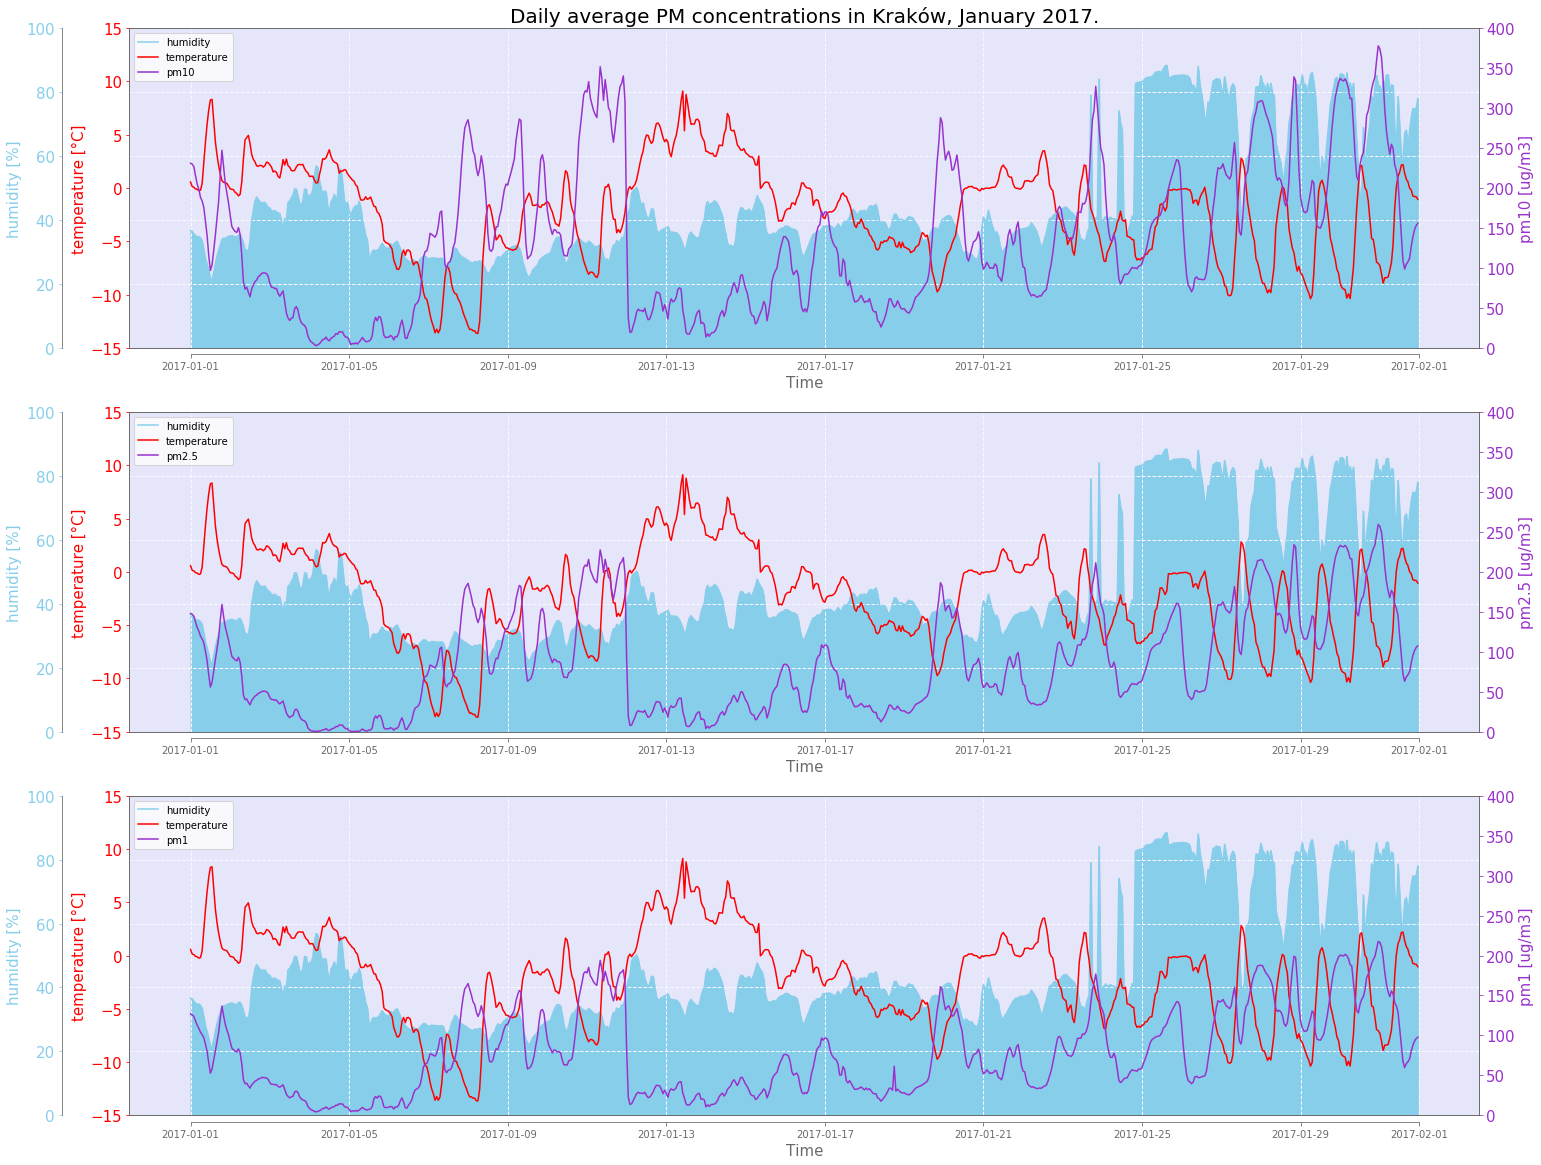

In [1016]:
# Plot charts for January
fig, ax = plt.subplots(3, figsize= [25,20])
fig.subplots_adjust(left=0.15)

ax[0].set_title('Daily average PM concentrations in Kraków, January 2017.', fontsize=20)

for pm_label, ax1 in zip(['pm10', 'pm2.5', 'pm1'], ax):

    labels = ['humidity', 'temperature', pm_label]
    colors = ['skyblue', 'red', 'darkorchid']
    units = ['%', '\N{DEGREE SIGN}C', 'ug/m3']

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax_list = [ax1, ax2, ax3]

    decorate_chart(ax1)

    # Shift humidity axis
    ax1.spines["left"].set_position(("axes", -0.05))

    # Swap temperature ticks to the left
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    # Draw charts
    plots = []
    for lbl, col, unit, ax in zip(labels, colors, units, ax_list):
        plot, = ax.plot(sensor_means[lbl.replace('.', '')][sensor_means[lbl.replace('.', '')].index.month == 1], color=col, label=lbl)
        ax.set_ylabel(lbl + ' [' + unit + ']', fontsize = 15)
        ax.tick_params(axis='y', colors=col)
        ax.yaxis.set_tick_params(labelsize = 15)
        ax.yaxis.label.set_color(col)
        plots.append(plot)

    ax1.legend(plots, [p.get_label() for p in plots])

    # Plot humidity chart filling
    ax1.fill_between(sensor_means['humidity'].index[sensor_means['humidity'].index.month == 1], 0,
                     sensor_means['humidity'][sensor_means['humidity'].index.month == 1], color=colors[0])

    ax1.set_ylim(0, 100)
    ax2.set_ylim(-15, 15)
    ax3.set_ylim(0, 400)

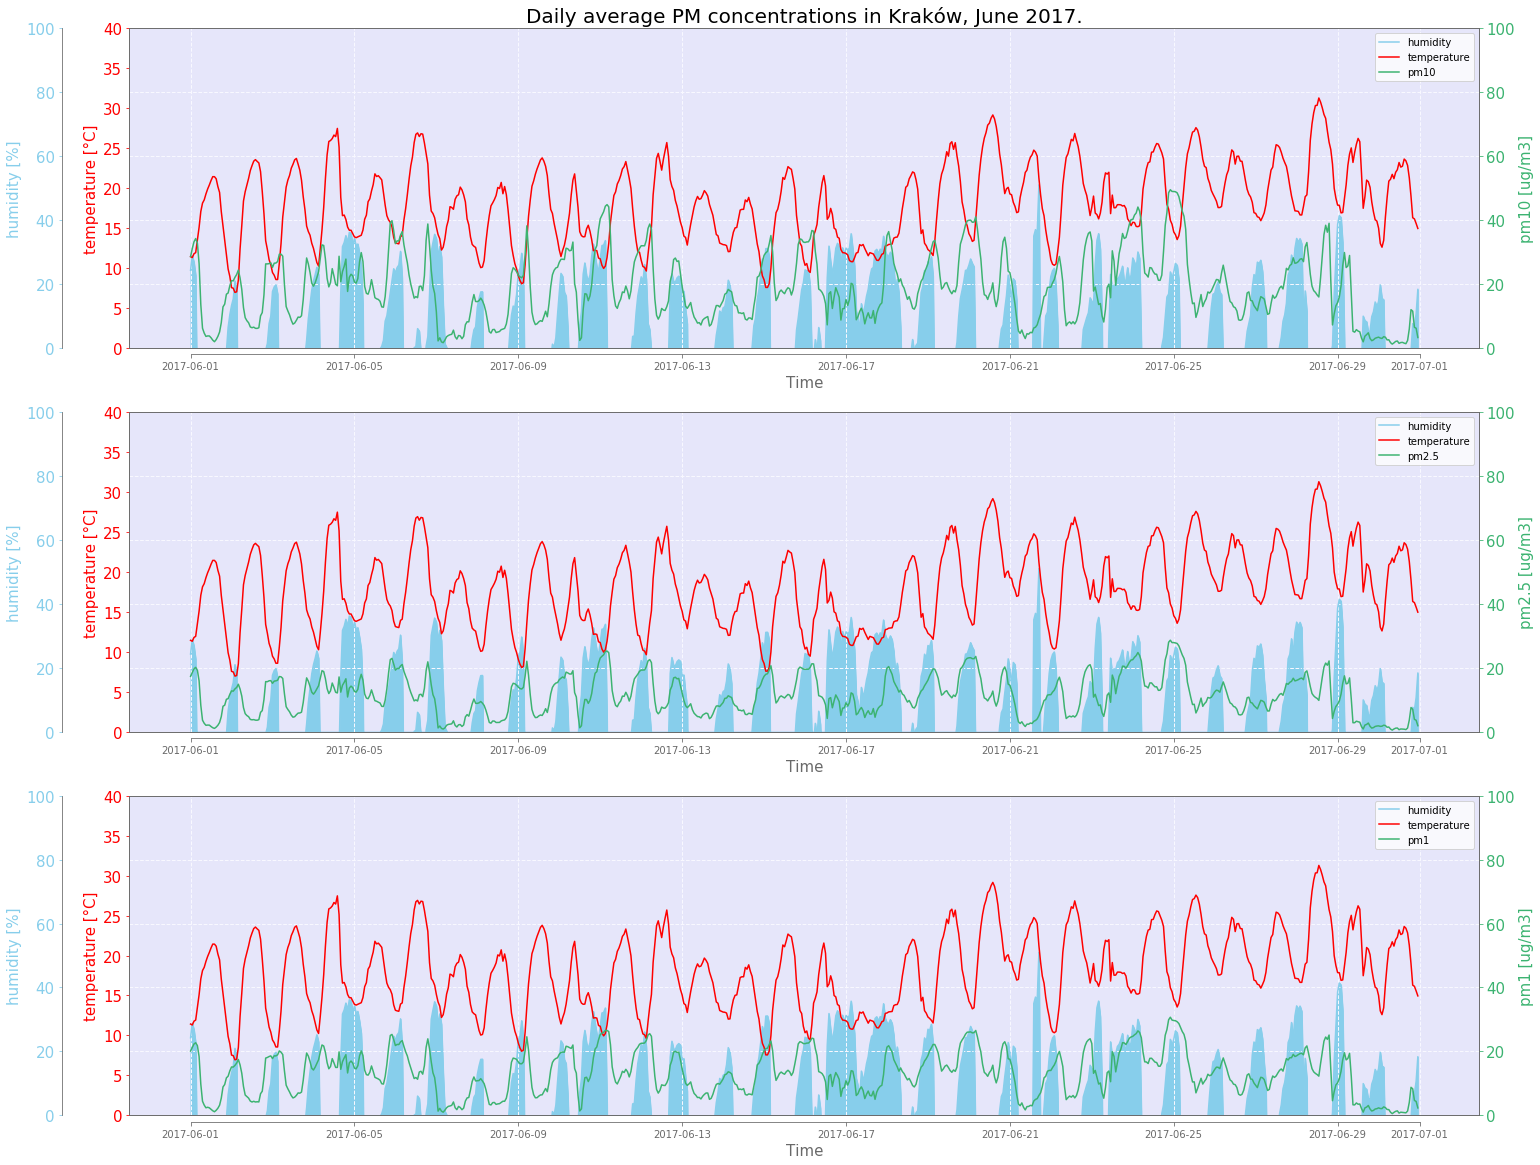

In [1017]:
# Plot charts for June
fig, ax = plt.subplots(3, figsize= [25,20])
fig.subplots_adjust(left=0.15)

ax[0].set_title('Daily average PM concentrations in Kraków, June 2017.', fontsize=20)

for pm_label, ax1 in zip(['pm10', 'pm2.5', 'pm1'], ax):

    labels = ['humidity', 'temperature', pm_label]
    colors = ['skyblue', 'red', 'mediumseagreen']
    units = ['%', '\N{DEGREE SIGN}C', 'ug/m3']

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax_list = [ax1, ax2, ax3]

    decorate_chart(ax1)
    ax1.spines['left'].set_smart_bounds(False)
    
    # Shift humidity axis
    ax1.spines["left"].set_position(("axes", -0.05))

    # Swap temperature ticks to the left
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    # Draw charts
    plots = []
    for lbl, col, unit, ax in zip(labels, colors, units, ax_list):
        plot, = ax.plot(sensor_means[lbl.replace('.', '')][sensor_means[lbl.replace('.', '')].index.month == 6], color=col, label=lbl)
        ax.set_ylabel(lbl + ' [' + unit + ']', fontsize = 15)
        ax.tick_params(axis='y', colors=col)
        ax.yaxis.set_tick_params(labelsize = 15)
        ax.yaxis.label.set_color(col)
        plots.append(plot)

    ax1.legend(plots, [p.get_label() for p in plots])

    # Plot humidity chart filling
    ax1.fill_between(sensor_means['humidity'].index[sensor_means['humidity'].index.month == 6], 0,
                     sensor_means['humidity'][sensor_means['humidity'].index.month == 6], color=colors[0])

    ax1.set_ylim(0, 100)
    ax2.set_ylim(0, 40)
    ax3.set_ylim(0, 100)



Średnia dobowa koncentracja pyłów drobnych PM10 oraz PM2.5 w okresie od stycznia do marca znacząco przekraczała przyjęte normy, z wyjątkiem okresu od 21 lutego do 15 marca. Temperatura w dniach poprzedzających ten okres oscylowała wokół 0 stopni celcjusza, co w połączeniu z wilgotnością na poziomie 80% mogło skutkować znacznie niższą odczuwalną temperaturą.

W dniu 21 lutego 2017 odnotowano wzrost temperatury do 5 stopni celcjusza a w okolicach 27 lutego temperatura wzrosła aż do 10 stopni celcjusza.
Ponowne przekroczenia norm można zaobserwować od listopada do grudnia.



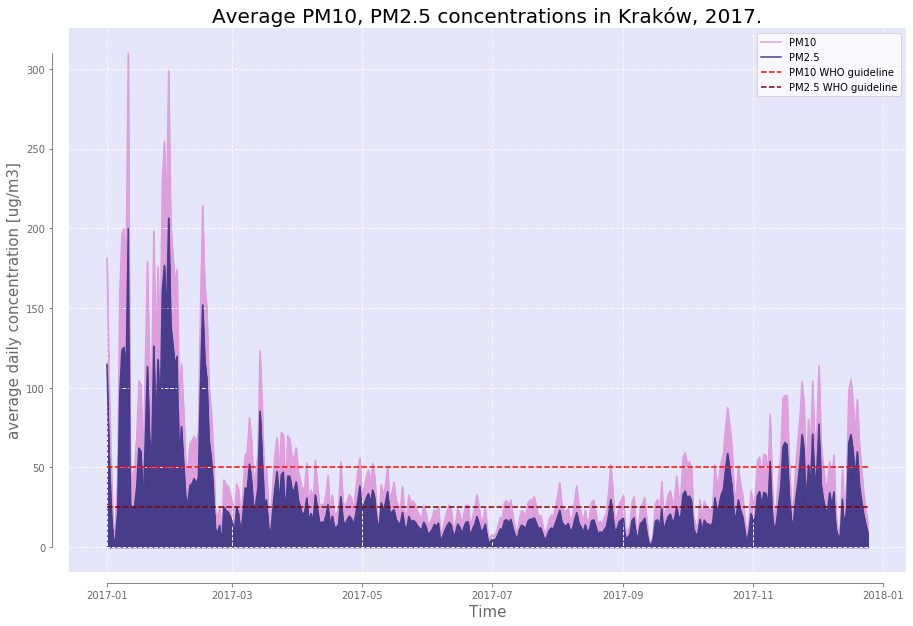

In [946]:
%matplotlib inline

fig, ax = plt.subplots(figsize= [15,10])

# Plot annual chart
ax.plot(daily_means['pm10'], color='plum', label='PM10')
ax.plot(daily_means['pm25'], color='darkslateblue', label='PM2.5')
ax.fill_between(daily_means['pm10'].index, 0, daily_means['pm10'], color='plum')
ax.fill_between(daily_means['pm25'].index, 0, daily_means['pm25'], color='darkslateblue')

# Plot guidelines
ax.hlines(pm10_daily_norm, daily_means['pm10'].index[0], daily_means['pm10'].index[-1], color='red', linestyle='--', zorder=3, label='PM10 WHO guideline')
ax.hlines(pm25_daily_norm, daily_means['pm10'].index[0], daily_means['pm10'].index[-1], color='maroon', linestyle='--', zorder=3, label='PM2.5 WHO guideline')

# Decorate figure
ax.set_title('Average PM10, PM2.5 concentrations in Kraków, 2017.', fontsize=20)
ax.set_ylabel('average daily concentration [ug/m3]', color='dimgray', fontsize = 15)
decorate_chart(ax)
ax.legend()

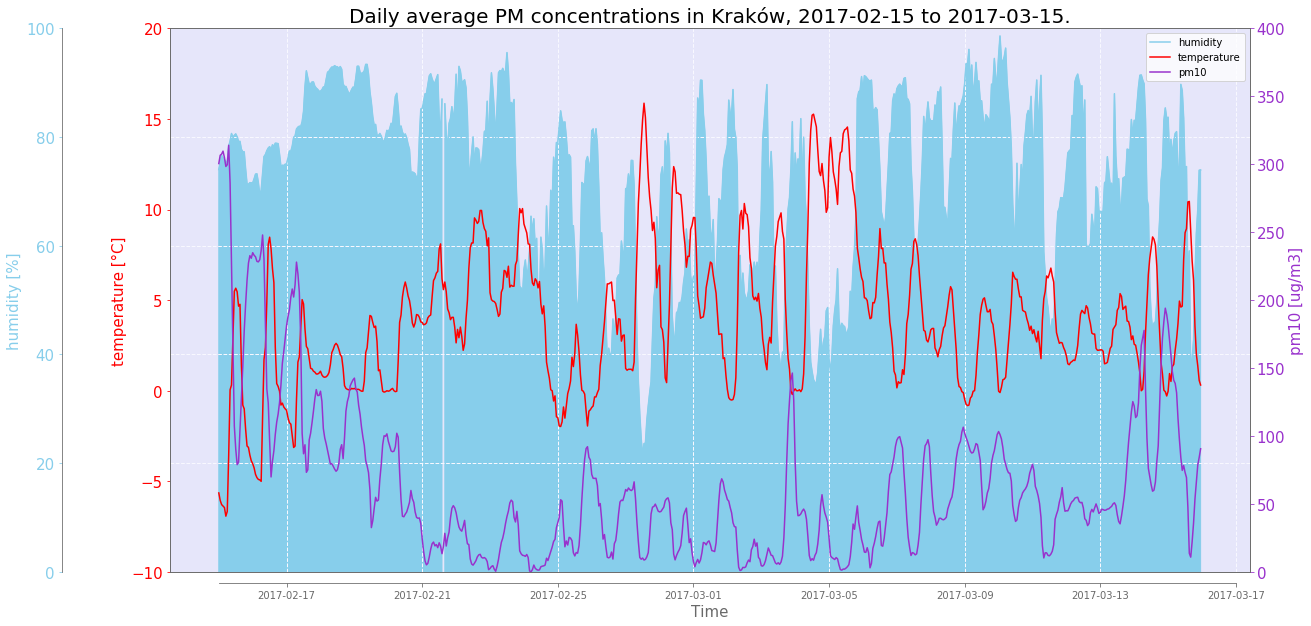

In [1011]:
fig, ax1 = plt.subplots(figsize= [20,10])
fig.subplots_adjust(left=0.15)

ax1.set_title('Daily average PM concentrations in Kraków, 2017-02-15 to 2017-03-15.', fontsize=20)

pm_label = 'pm10'
labels = ['humidity', 'temperature', pm_label]
colors = ['skyblue', 'red', 'darkorchid']
units = ['%', '\N{DEGREE SIGN}C', 'ug/m3']

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax_list = [ax1, ax2, ax3]

decorate_chart(ax1)

# Shift humidity ax
ax1.spines["left"].set_position(("axes", -0.1))

# Swap temperature ax to the left
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

# Draw charts
plots = []
for lbl, col, unit, ax in zip(labels, colors, units, ax_list):
    plot, = ax.plot(sensor_means[lbl].loc['2017-02-15 00:00:00':'2017-03-15 23:00:00', ], color=col,
                    label=lbl)
    ax.set_ylabel(lbl + ' [' + unit + ']', fontsize=15)
    ax.tick_params(axis='y', colors=col)
    ax.yaxis.set_tick_params(labelsize = 15)
    ax.yaxis.label.set_color(col)
    plots.append(plot)

ax1.legend(plots, [p.get_label() for p in plots])

# Plot humidity chart filling
ax1.fill_between(sensor_means['humidity'].loc['2017-02-15 00:00:00':'2017-03-15 23:00:00', ].index, 0,
                 sensor_means['humidity'].loc['2017-02-15 00:00:00':'2017-03-15 23:00:00', ], color=colors[0])

ax1.set_ylim(0, 100)
ax2.set_ylim(-10, 20)
ax3.set_ylim(0, 400)



plt.show()      



Aby potwierdzić powyższe interpretacje obliczyłam macierz korelacji dla średnich wartości parametrów z której wynika iż:

1. Istnieje silna dodatnia korelacja pomiędzy rodzajami pyłów zawieszonych PM10,PM2.5,PM1
2. Istnieje znacząca ujemna korelacja pomiędzy rodzajem pyłu a temperaturą (wraz ze spadkiem temperatury maleje poziom natężenia danego pyłu)
3. Istnieje zauważalna dodatnia korelacja pomiędzy rodzajem pyłu a wilgotnością powietrza 


In [1018]:
correlations_data = pd.DataFrame(sensor_means)
correlations_data =pd.DataFrame(correlations_data.corr())
correlations_data.style.background_gradient(cmap='PuRd')

,pm10,pm25,pm1,temperature,humidity
pm10,1.000000,0.996392,0.994772,-0.568568,0.261222
pm25,0.996392,1.000000,0.996803,-0.547304,0.260581
pm1,0.994772,0.996803,1.000000,-0.552774,0.259256
temperature,-0.568568,-0.547304,-0.552774,1.000000,-0.417777
humidity,0.261222,0.260581,0.259256,-0.417777,1.000000


### Wartości odstające

Aby znaleźć wartości odstające zdecydowałam się zastosować metodę rozstępu międzykwartylowego. 
Analizie zostały poddane 4 sensory, dla których średnie natężenie pyłu drobnego PM10 w styczniu (miesiącu najbardziej zanieczyszonym) było największe.

Jeżeli dany odczyt byłby mniejsze niż różnica pierwszego kwantyla oraz rozstępu międzykwantylowego pomnożonego przez 1.5 lub dany odczyt byłby większy niż suma trzeciego kwantyla oraz rozstępu międzykwantylowego pomnożonego przez 1.5, wówczas można daną wartość sklasyfikować jako wartość odstającą. 

Aby mieć pełny obraz danych, zdecydowałam się uzupełnić brakujące obserwacje za pomocą algorytmu najbliższego sąsiada. Dane, ze względu na różne jednostki pomiaru, zostały znormalizowane. 

In [858]:
m = 1

january_pm10_means = data.loc[data.index.month == m, data.columns.str.endswith('pm10')].mean(axis=0)

top_pm10_sensors = list(january_pm10_means.nlargest(4).index)
top_pm10_sensors = [s.split('_')[0] for s in top_pm10_sensors]
print(top_pm10_sensors)

data_normalized = pd.DataFrame(index=data.index)

for column in data.columns:
    data_normalized[column] = (data[column] - np.nanmean(data[column], axis=0))/np.nanstd(data[column], axis=0)

january_pm10 = pd.DataFrame(index=data_normalized.index)
january_pm10 = january_pm10.loc[january_pm10.index.month == m, ]

for sensor in top_pm10_sensors:
    sensors_normalized = data_normalized.loc[:, data_normalized.columns.str.startswith(sensor+'_')]
    imputer = KNNImputer(n_neighbors=10)
    kNN_imputer = imputer.fit_transform(sensors_normalized)
    sensor_transformed = pd.DataFrame(kNN_imputer, columns=sensors_normalized.columns, index=data_normalized.index)
    january_pm10[sensor+'_'+'pm10'] = sensor_transformed.loc[sensor_transformed.index.month == m, sensor_transformed.columns.str.endswith('pm10')]

['225', '222', '202', '192']


Sensory dla których udało mi się zlokalizować wartości odstające to:

1. 225 - Kraków Dębniki
2. 222 - Bielańsko-Tyniecki Park Krajobrazowy
3. 202 - Łagiewniki - Borek Fałęcki
4. 192 - Bielańsko-Tyniecki Park Krajobrazowy 

3 z 4 zidentyfikowanych sensorów leżą w rejonach Bielańsko-Tynieckiego Park Krajobrazowego.


(736330.0416666666, 736361.0)

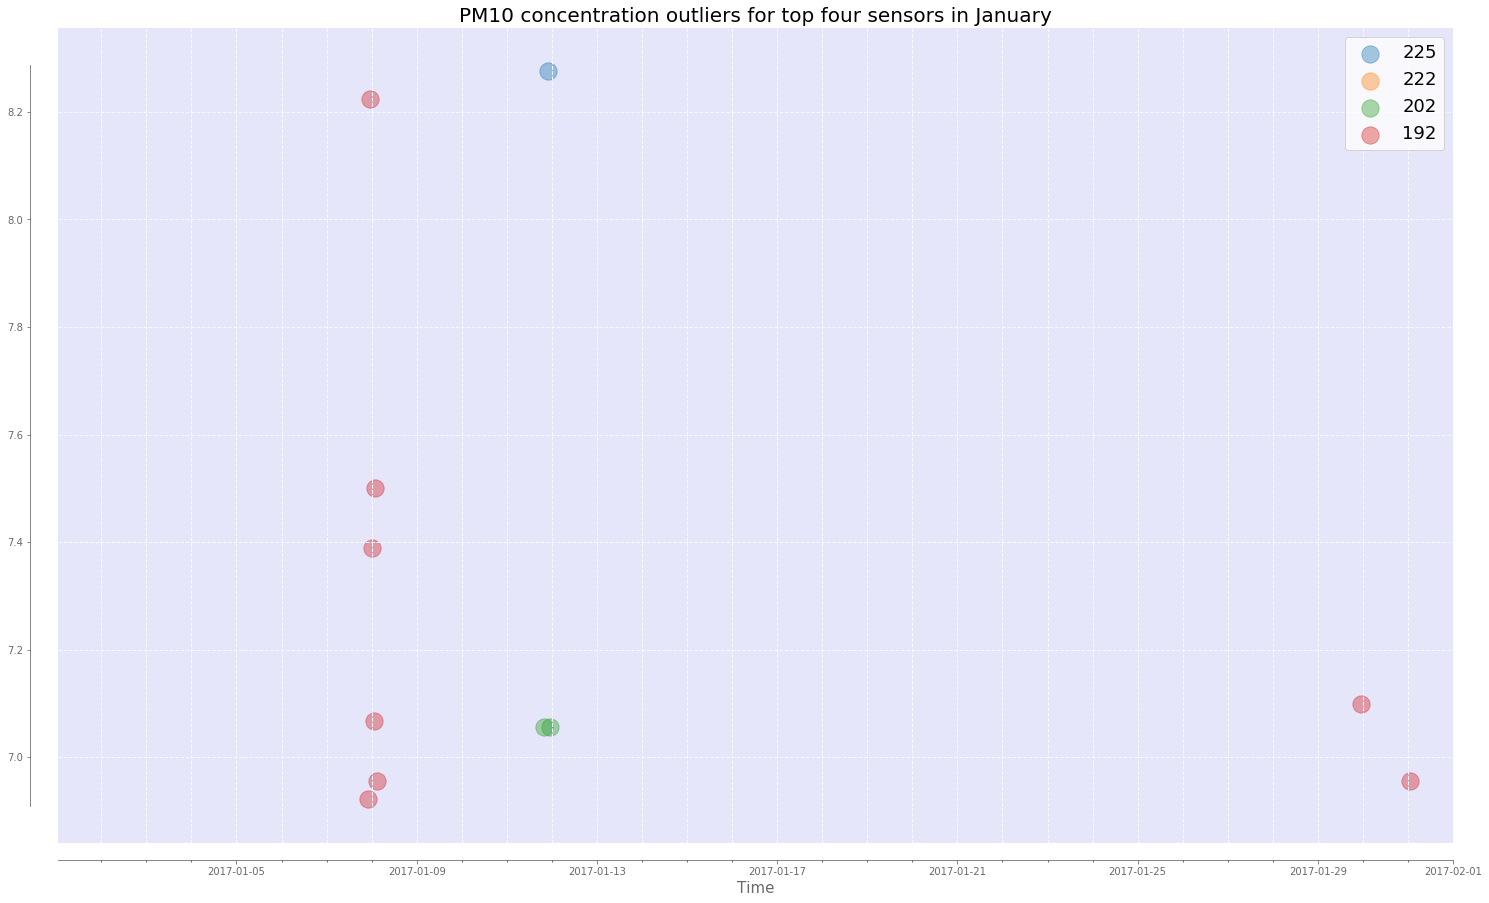

In [932]:
fig, ax1 = plt.subplots( figsize= [25,15])

for column in january_pm10.columns:
#first and third quartile
    first_quartile = january_pm10[column].describe()['25%']
    third_quartile = january_pm10[column].describe()['75%']
#interquartile range
    iqr = third_quartile - first_quartile

    outliers_data = pd.DataFrame(columns=[column], index=january_pm10.index)

    for i, v in zip(january_pm10.index, january_pm10[column]):
        if (v < (first_quartile - 1.5 * iqr)) or (v > (third_quartile + 1.5 * iqr)):
            outliers_data.at[i, column] = v

    plt.scatter(outliers_data.index, outliers_data, s=300, label=column.split('_')[0], alpha=0.4)

ax1.set_xticks(january_pm10.resample('1D').sum().index, minor=True)
decorate_chart(ax1)
ax1.set_title("PM10 concentration outliers for top four sensors in January", fontsize=20)
ax1.legend(fontsize = 18)
ax1.set_xlim(pd.to_datetime('2017-01-01 01:00:00'), pd.to_datetime('2017-02-01 00:00:00'))

## Model prognostyczny

Do prognozy wybrałam pomiar poziomu natężenia pyłu drobnego PM10, zarejestrowanego na sensorze 212.  

In [882]:
sensor_212 = data.loc[:,data.columns.str.contains('212')]
sensor_212_pm10 = sensor_212['212_pm10']

### Braki danych

Brakujące wartości zastąpiłam średnią dla całej zmiennej. Wybrałam tą metodę gdyż jest ona najszybsza, a brakujących wartości było jedynie 8. W przypadku, gdy braków danych byłoby znacznie więcej można, zastosować inne metody, na przykład algorytm najbliższego sąsiada albo regresję.

In [883]:
print('Missing values: ' + str(sensor_212_pm10.isnull().sum()))

Missing values: 8


In [884]:
mean_212_pm10 = sensor_212_pm10.mean()
sensor_212_pm10.fillna(mean_212_pm10, inplace=True)
print('Missing values after transformation: ' + str(sensor_212_pm10.isnull().sum()))


Missing values after transformation: 0


Na wykresie wartości natężenia pyłu PM10 od czasu nie zaobserwowałam wyraźnego trendu lub wahań sezonowych. Dlatego też nie zdecydowałam się na logarytmowanie czy różnicowanie danych. Można przypuszczać że, w kolejnych latach wartości dla poszczególnych miesięcy będa podobne ze względu na rozpoczęcie lub zakończenie sezonu grzewczego oraz natężenie ruchu. 


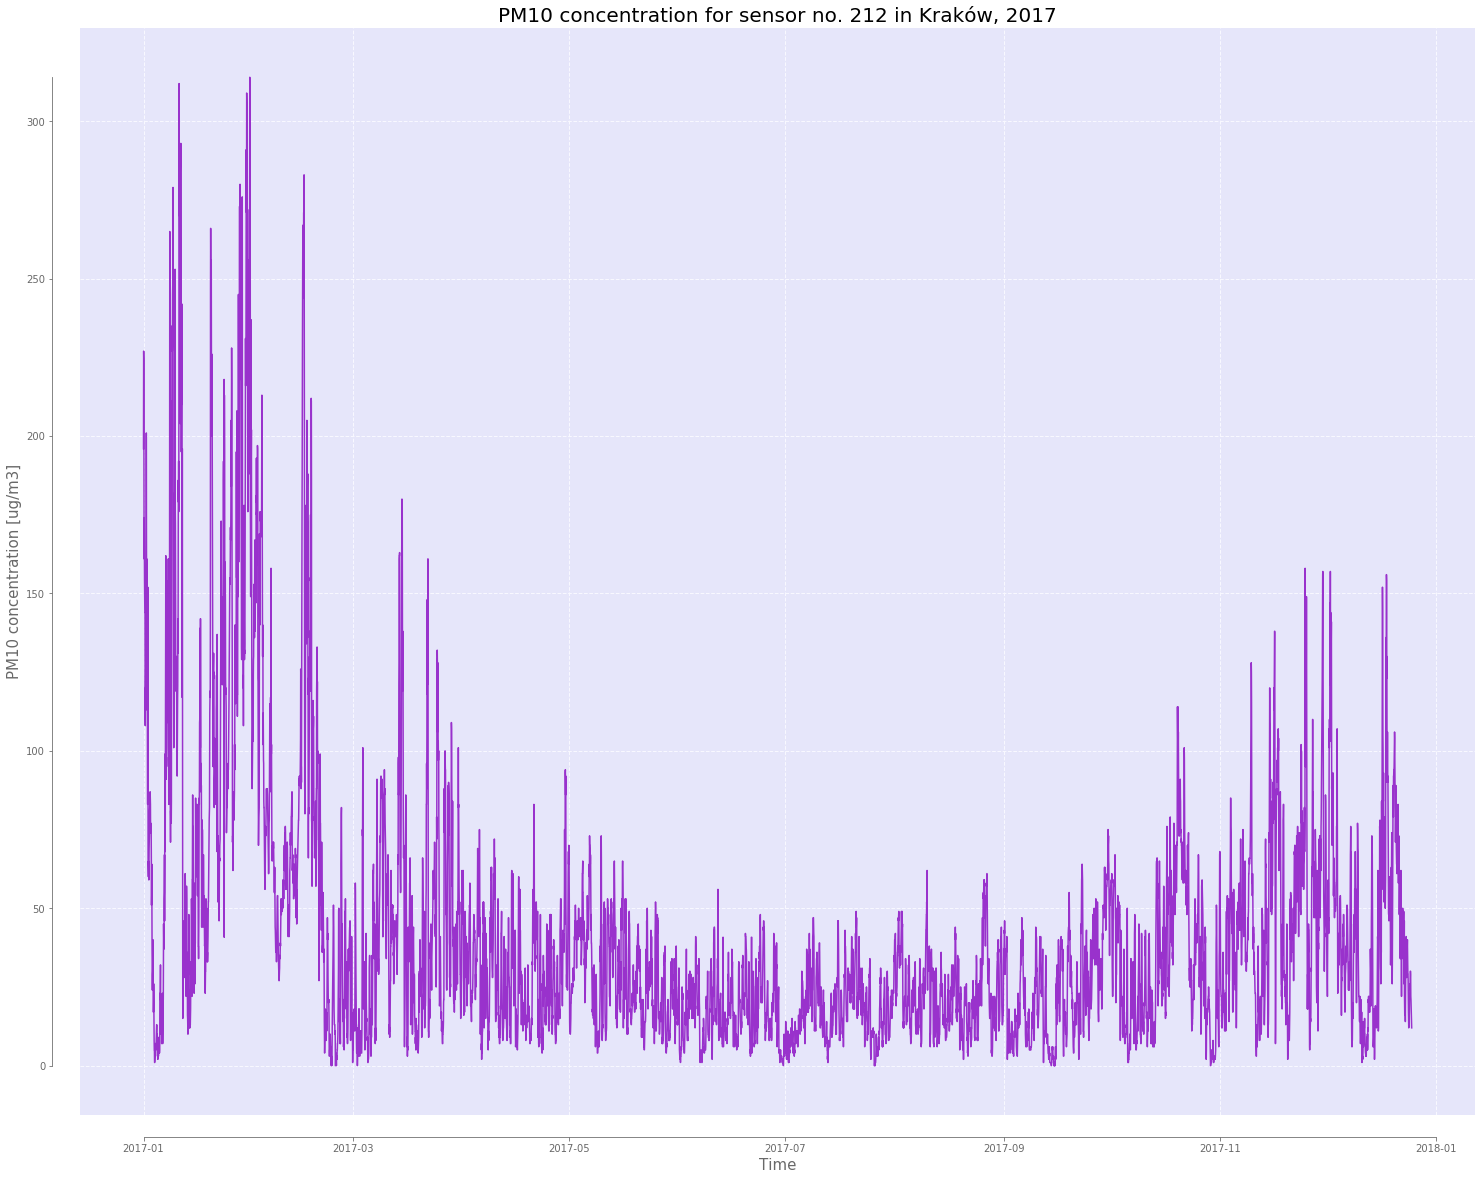

In [940]:
%matplotlib inline

fig = plt.figure(figsize= [25,20])
ts_plot = plt.gca()
plt.plot(sensor_212_pm10, color = 'darkorchid')
ts_plot.set_title('PM10 concentration for sensor no. 212 in Kraków, 2017', fontsize = 20)
ts_plot.set_ylabel('PM10 concentration [ug/m3]', fontsize=15, color = 'dimgray')
decorate_chart(ts_plot)



### Stacjonarność szeregu czasowego

Aby wybrać odpowiedni model do prognozy zjawiska, sprawdziłam stacjonarność szeregu czasowego dwoma testami. Pierwszy to Test Dickeya-Fullera, którego hipoteza zerowa mówi o obecności pierwiastka jednostkowego a w konsekwencji o niestacjonarności szeregu. P-value dla tego testu wynosi 9* 10^(-6), czyli bardzo mało. Na każdym poziomie istotności możemy odrzucić hipotezę zerową i przyjąć alternatywną mówiącą o stacjonarności szeregu.

Drugim testem jest jest KPSS, któego hipoteza zerowa mówi iż badany szereg jest stacjonarny. W tym wypadku możemy jedynie na poziomie istotności równym 1% przyjąć, iż nie ma podstaw do odrzucenia hipotezy zerowej, mówiącej o stacjonarności badanego szeregu.

In [1030]:

df_test = adfuller(sensor_212_pm10, autolag='AIC')
p_value = df_test[1]
confidence_levels = [0.01,0.05,0.1]


for i in confidence_levels:
    if p_value > i:
        print('The data is not stationary with '+ str(int(round(i*100,2))) + '% confidence') 
    else:
        print('The data is stationary with '+ str(int(round(i*100,2))) + '% confidence')

The data is stationary with 1% confidence
The data is stationary with 5% confidence
The data is stationary with 10% confidence


In [1029]:
kpss_test = kpss(sensor_212_pm10, 'ct')
p_value = kpss_test[1]

for i in confidence_levels:
    if p_value >= i:
        print('The data is stationary with '+ str(int(round(i*100,2))) + '% confidence') 
    else:
        print('The data is not stationary with '+ str(int(round(i*100,2))) + '% confidence')
        

The data is stationary with 1% confidence
The data is not stationary with 5% confidence
The data is not stationary with 10% confidence


### Autokorelacja

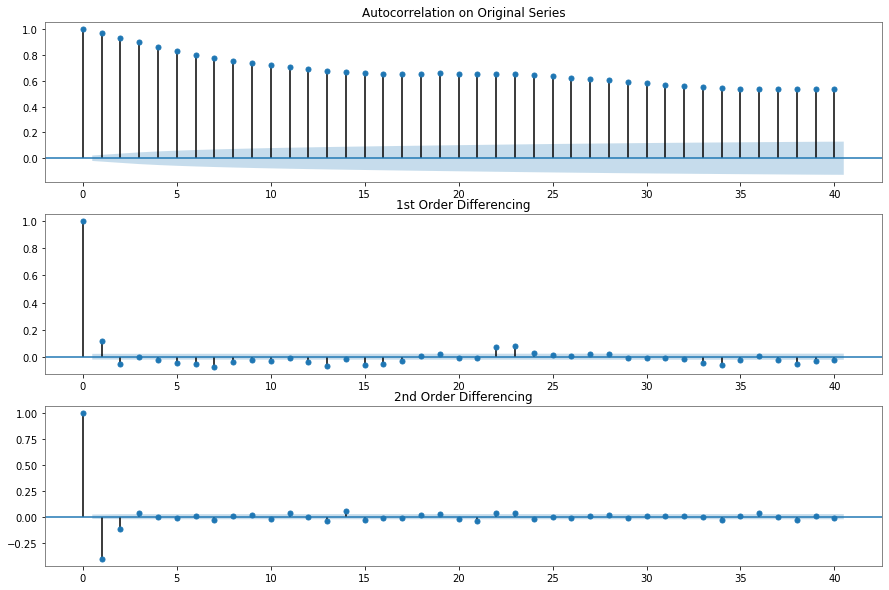

In [889]:

fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(311)
fig = plot_acf(sensor_212_pm10, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(sensor_212_pm10.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(sensor_212_pm10.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

### Wybór modelu

Do prognozy natężenia pyłu PM10 użyłam modelu ARIMA(1,0,0), czyli upraszczając, modelu AR(1) - model autoregresyjny z jednym opóźnieniem zmiennej objaśnianej. Zdecydowałam się pominąć parametry odpowiadające za różnicowanie (integrację) i średnią ruchomą, gdyż badany szereg jest szeregiem stacjonarnym bez wahań sezonowych. Można podejrzewać, że po dodaniu do szeregu danych z kilku poprzednich lat, wahania będą widoczne, a dane nie będą już stacjonarne. Wówczas można zastosować różnicowanie aby uzyskać stacjonarność danych oraz parametr średniej ruchomej do wygładzenia wahań. 

Opóźnienie modelu wybrałam za pomocą kryterium Akaike. 

In [890]:
Akaike_list = []

for lag in range(1,25):
    model = ARIMA(sensor_212_pm10, order = (lag, 0, 0))
    fit_model = model.fit()
    aic = fit_model.aic
    Akaike_list.append(aic)
    #print('ARIMA(' + str(i) + ',0,0) akaike criterion: ' + str(aic))


In [891]:
print(Akaike_list)
Akaike_max = Akaike_list.index(max(Akaike_list))
print(Akaike_max)

[63919.319579257746, 63765.810173431964, 63748.07431034271, 63743.65823877342, 63744.31211341031, 63740.14857473658, 63734.90858020852, 63710.45051847964, 63710.23660323968, 63710.026712140054, 63706.10174406051, 63708.09439909679, 63692.46340464115, 63659.67796929914, 63660.364592411424, 63613.16403744763, 63592.31617114815, 63576.290116094766, 63577.86905490888, 63579.214624738306, 63565.450886238934, 63561.41556437727, 63546.8347719539, 63531.33848319067]
0


### Prognoza

Prognozy dla natężenia pyłu PM10 w Krakowie na okres od 25 grudnia 2019 do 25 stycznia 2018 dla sensora 212 wyszły na poziomie 40 mikrogramów na metr sześcienny (natężenie godzinowe). 

Posiadając dane rzeczywiste na ten okres można obliczyć oceny ex-post prognoz. Bez tej wiedzy mogę jednak powiedzieć, iż te prognozy są zaniżone. Średnia wartość natężenia pyłu pm10 dla badanego sensora w grudniu wynosiła około 46 mikrogramów na metr sześcienny natomiast dla stycznia 109 mikrogramów na metr sześcienny. 

W celu poprawienia modelu należałoby zanalizować zdecydowanie większy okres (na przykład kilku lat) i dobrać odpowiednie parametry. 


In [892]:
model = ARIMA(sensor_212_pm10, order = (1, 0, 0))
fit_model = model.fit()
#print(fit_model.summary())

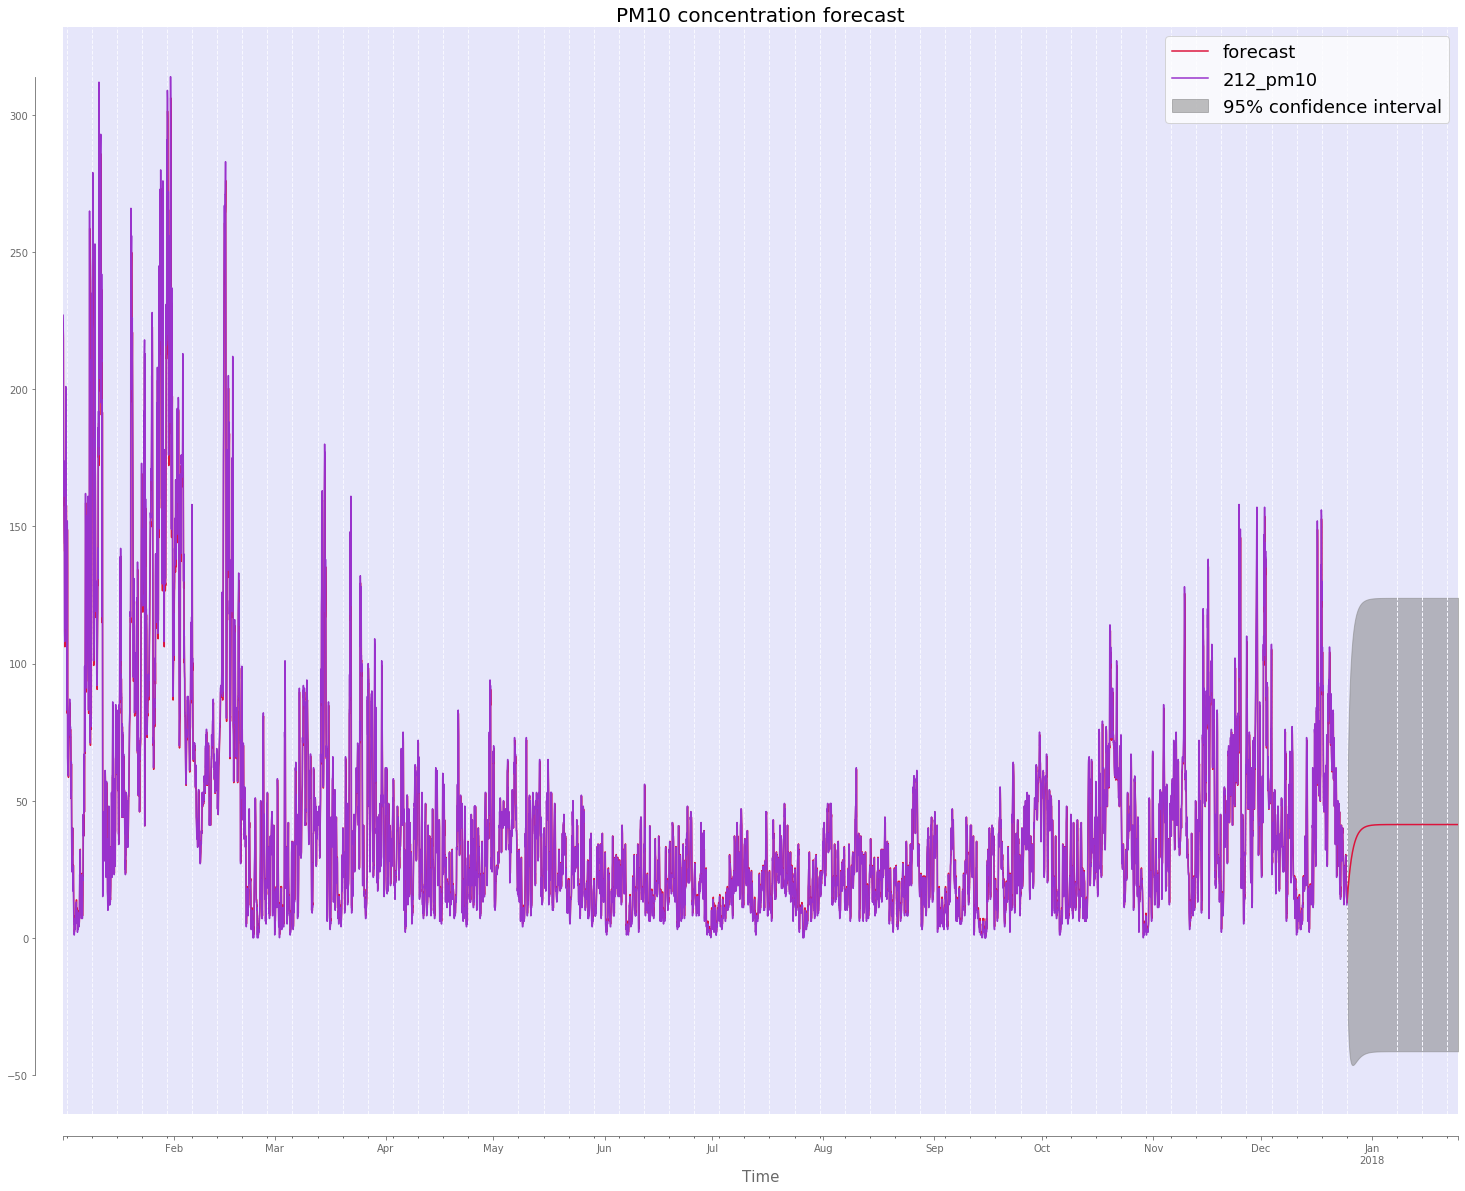

In [957]:
#predictions_ARIMA = fit_model.predict(start = '2017-01-01 01:00:00', end = '2018-01-25 00:00:00')


fig = plt.figure(figsize= [25,20])
ax = fig.gca()
decorate_chart(ax)
fig = fit_model.plot_predict(start = '2017-01-01 01:00:00', end = '2018-01-25 00:00:00', ax=ax)

ax.set_title('PM10 concentration forecast', fontsize=20)
lines=ax.get_lines()
lines[0].set_color('crimson')
lines[1].set_color('darkorchid')

ax.legend(fontsize=18)

In [1020]:
predictions_ARIMA = fit_model.predict(start = '2017-01-01 01:00:00', end = '2018-01-25 00:00:00')
predictions_ARIMA = pd.DataFrame(predictions_ARIMA, columns = ['Forecast'])
predictions_ARIMA = predictions_ARIMA.loc['2017-12':'2018-2',]
